Fitting 5 folds for each of 1 candidates, totalling 5 fits
RMSE for master_data_setV0.csv: 4261.501645811336
Best hyperparameters for master_data_setV0.csv: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


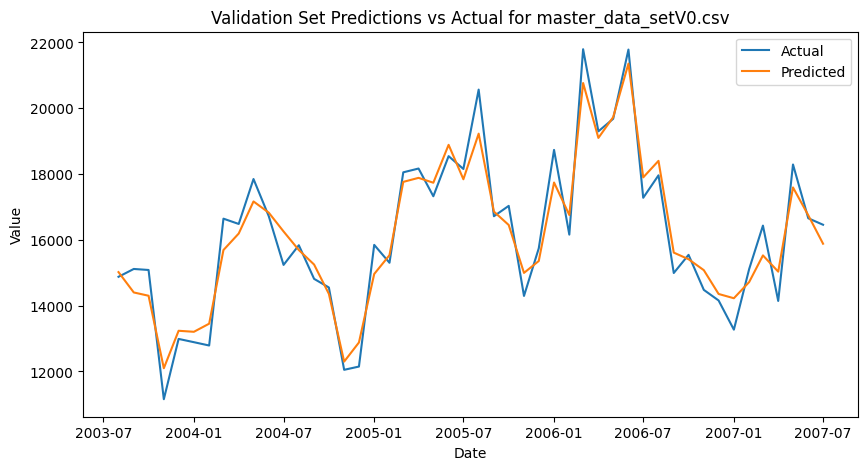

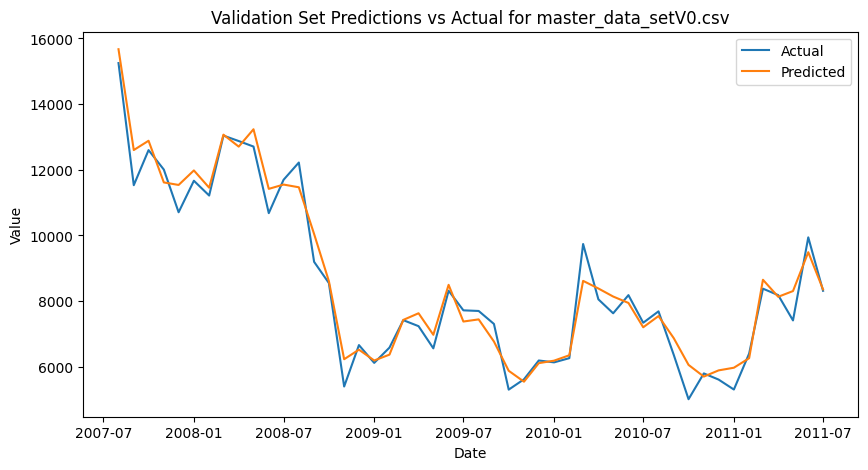

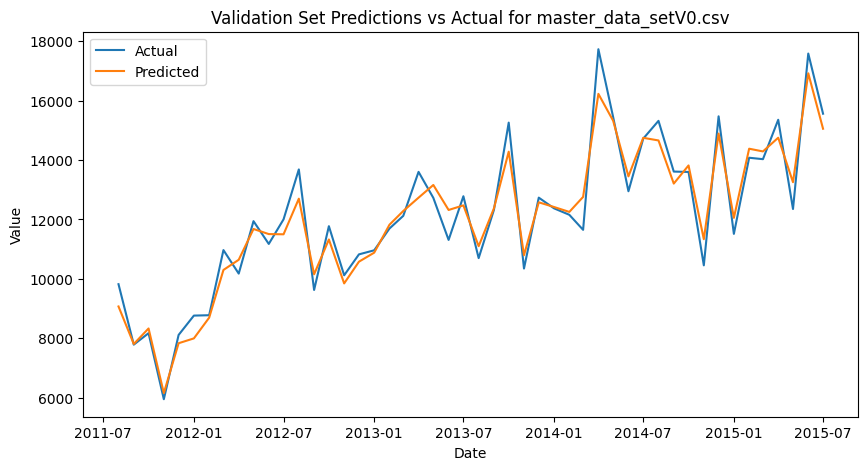

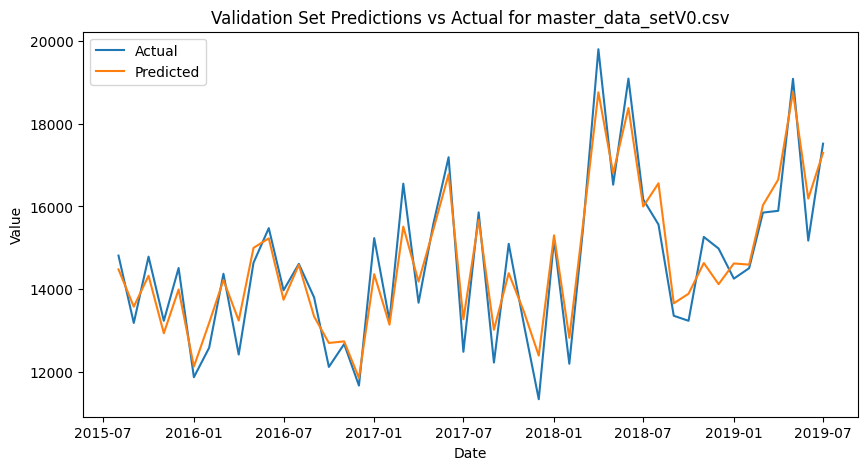

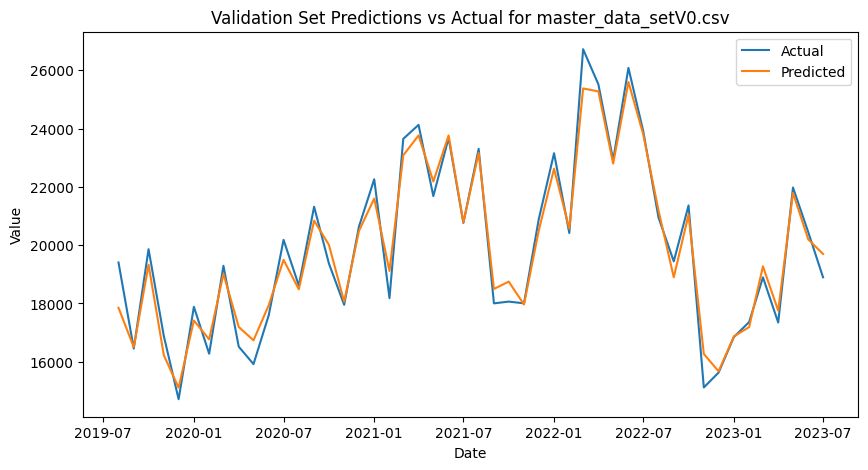

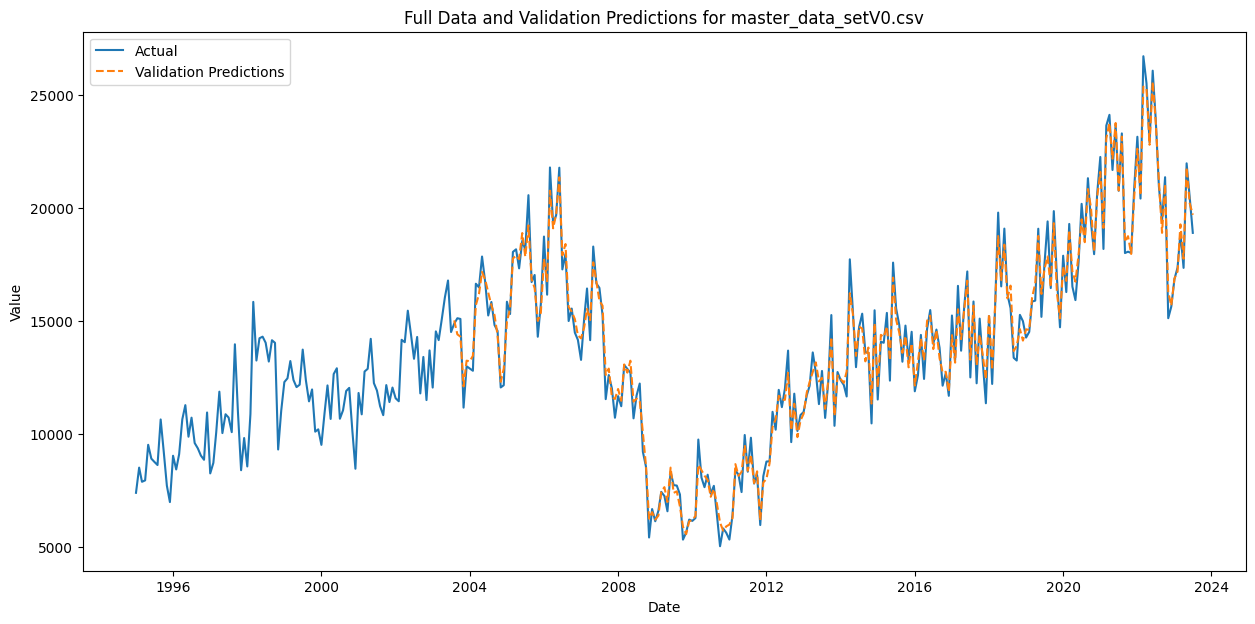

master_data_setV0.csv: RMSE = 4261.501645811336
master_data_setV0.csv: Best hyperparameters = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Assume you have a list of dataframes here
dataframe_names = ['master_data_setV0.csv']  # Add your CSV file names here

# Parameter grid for grid search
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'min_child_weight': [1, 5, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 150, 200],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

param_grid = {
    'max_depth': [3],
    'min_child_weight': [1],
    'learning_rate': [0.1],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Initialize TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5, test_size=24, random_state=42)
tscv = TimeSeriesSplit(n_splits=5, test_size=48)

# This will store the best models for each dataframe
best_models = {}
# This will store the RMSE for each model
model_rmse = {}
# This will store the best hyperparameters for each dataframe
best_hyperparams = {}


# Loop over each dataframe
for file_name in dataframe_names:
    # Load the data
    df = pd.read_csv(file_name)
    
    # Include your preprocessing here
    # ...
    
    # Define the columns you want to use
    # ...
    
    # Assuming 'Value' is the target variable and 'Date' is the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    df = df[df['State'] == 'Texas']  # Or whatever state you're filtering by
    df = df.drop(columns=['State', 'Division'])

    # Define the train and validation sets
    X, y = df.drop('Value', axis=1), df['Value']

    # Initialize the XGBRegressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Set up GridSearchCV with TimeSeriesSplit
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=tscv, verbose=1)

    # Use the grid search to find the best parameters
    grid_search.fit(X, y)

    # Get the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    best_hyperparams[file_name] = grid_search.best_params_

    # Store the best model and RMSE in the dictionaries
    best_models[file_name] = best_model
    # The best score is the negative MSE, so we take its square root and change the sign for RMSE
    model_rmse[file_name] = np.sqrt(-grid_search.best_score_)

    # Print the RMSE and best hyperparameters for the best model
    print(f"RMSE for {file_name}: {model_rmse[file_name]}")
    print(f"Best hyperparameters for {file_name}: {best_hyperparams[file_name]}")
    
    # For plotting the entire data with validation predictions
    validation_predictions = np.empty_like(y)
    validation_predictions[:] = np.nan

    
    for train_index, val_index in tscv.split(X):
        # Split the data
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Make predictions
        predictions = best_model.predict(X_val)
        validation_predictions[val_index] = predictions  # Store predictions


        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(y_val.index, y_val, label='Actual')
        plt.plot(y_val.index, predictions, label='Predicted')
        plt.title(f'Validation Set Predictions vs Actual for {file_name}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, y, label='Actual')
    plt.plot(df.index, validation_predictions, label='Validation Predictions', linestyle='--')
    plt.title(f'Full Data and Validation Predictions for {file_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Print all RMSEs and hyperparameters
for name, rmse in model_rmse.items():
    print(f"{name}: RMSE = {rmse}")
    print(f"{name}: Best hyperparameters = {best_hyperparams[name]}")


# Optionally, save the model to disk
# import joblib
# for name, model in best_models.items():
#     joblib.dump(model, f'{name}_best_xgb_model.pkl')
